In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
import pipeline_script
import seaborn as sns
import math
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.preprocessing import MinMaxScaler

## Importing Participant Information

In [2]:
participant_df = pd.read_csv(r"participant_info.csv")

In [3]:
participant_df = participant_df.set_index("SID")

In [4]:
participant_df.columns

Index(['AGE', 'GENDER', 'BMI', 'OAHI', 'AHI', 'Mean_SaO2', 'Arousal Index',
       'MEDICAL_HISTORY', 'Sleep_Disorders'],
      dtype='object')

### One Hot Encoding The Medical History

In [4]:
med_hist = []
for id,data in participant_df[~participant_df["MEDICAL_HISTORY"].isna()].iterrows():
    for token in data["MEDICAL_HISTORY"].split(","):
        token = token.lower().strip()
        any_found = False
        for condition in med_hist:
            found = bool(re.search(condition, token, re.IGNORECASE))
            if found:
                any_found = True
                participant_df.loc[id,condition] = 1
            else:
                participant_df.loc[id,condition] = 0
        if not any_found:
            participant_df[token] = 0
            participant_df.loc[id,token] = 1
            med_hist.append(token)

In [5]:
disorder_hist = []
for id,data in participant_df[~participant_df["Sleep_Disorders"].isna()].iterrows():
    for token in data["Sleep_Disorders"].split(","):
        token = token.lower().strip()
        any_found = False
        for condition in disorder_hist:
            found = bool(re.search(condition, token, re.IGNORECASE))
            if found:
                any_found = True
                participant_df.loc[id,condition] = 1
            else:
                participant_df.loc[id,condition] = 0
        if not any_found:
            participant_df[token] = 0
            participant_df.loc[id,token] = 1
            disorder_hist.append(token)

In [7]:
participant_df.columns

Index(['AGE', 'GENDER', 'BMI', 'OAHI', 'AHI', 'Mean_SaO2', 'Arousal Index',
       'MEDICAL_HISTORY', 'Sleep_Disorders', 'asthma', 'body pain', 'gerd',
       'hypertension', 'sleep apnea', 'arrhythmia', 'depression', 'dyspnea',
       'diabetes', 'cad', 'anxiety', 'migraine', 'osa', 'snoring',
       'difficulty breathing', 'snorts', 'difficulty staying asleep', 'snort',
       'rls', 'chronic fatigue', 'eds', 'rbd', 'hypersomnia', 'grind teeth',
       'insomnia', 'fatigue', 'morning headaches', 'bruxism',
       'diffifulty breathing', 'grinds teeth', 'snore', 'none', 'headache'],
      dtype='object')

In [8]:
counts = participant_df.apply(lambda x: (x == 1).sum())
counts

AGE                           0
GENDER                        0
BMI                           0
OAHI                         14
AHI                           8
Mean_SaO2                     0
Arousal Index                 0
MEDICAL_HISTORY               0
Sleep_Disorders               0
asthma                        2
body pain                     4
gerd                          5
hypertension                 32
sleep apnea                  12
arrhythmia                    1
depression                    8
dyspnea                       4
diabetes                      2
cad                           0
anxiety                       1
migraine                      5
osa                          23
snoring                      14
difficulty breathing          2
snorts                        3
difficulty staying asleep     0
snort                         4
rls                           6
chronic fatigue               1
eds                          18
rbd                           1
hypersom

### Merge same columns

In [6]:
participant_df['snort'] = (participant_df['snorts'] | participant_df['snort']).astype(int)
participant_df = participant_df.drop("snorts",axis=1)
participant_df['grind teeth'] = (participant_df['grind teeth'] | participant_df['grinds teeth']).astype(int)
participant_df = participant_df.drop("grinds teeth",axis=1)
participant_df['difficulty breathing'] = (participant_df['difficulty breathing'] | participant_df['diffifulty breathing']).astype(int)
participant_df = participant_df.drop("diffifulty breathing",axis=1)
participant_df['fatigue'] = (participant_df['chronic fatigue'] | participant_df['fatigue']).astype(int)
participant_df = participant_df.drop("chronic fatigue",axis=1)
participant_df = participant_df.drop("none",axis = 1)

In [7]:
columns_normalize = ["AGE","BMI"]

In [8]:
scaler = MinMaxScaler()
participant_df_normalized = participant_df.copy()
participant_df_normalized[columns_normalize] = scaler.fit_transform(participant_df[columns_normalize])

In [9]:
participant_df_normalized.to_csv("participant_info_processed.csv")

In [13]:
counts = participant_df.apply(lambda x: (x == 1).sum())
counts

AGE                           0
GENDER                        0
BMI                           0
OAHI                         14
AHI                           8
Mean_SaO2                     0
Arousal Index                 0
MEDICAL_HISTORY               0
Sleep_Disorders               0
asthma                        2
body pain                     4
gerd                          5
hypertension                 32
sleep apnea                  12
arrhythmia                    1
depression                    8
dyspnea                       4
diabetes                      2
cad                           0
anxiety                       1
migraine                      5
osa                          23
snoring                      14
difficulty breathing          2
difficulty staying asleep     0
snort                         5
rls                           6
eds                          18
rbd                           1
hypersomnia                   1
grind teeth                   4
insomnia

## Importing Clean Data From Pipeline Script

In [4]:
patient_records = pipeline_script.gather_dict("dreamt-dataset-for-real-time-sleep-stage-estimation-using-multisensor-wearable-technology-1.0.1\data\\")

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


In [15]:
patient_records["S002"].columns

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'Sleep_Stage', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea',
       'Multiple_Events', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'ACC'],
      dtype='object')

### Erasing 027 and 077, we won't use them in training nor prediction.

In [5]:
patient_records.pop("S027") 
patient_records.pop("S077")
print("S027" in patient_records.keys() or "S077" in patient_records.keys())

False


## Searching for NaN values

In [13]:
patient_records_no_process = pipeline_script.gather_dict("dreamt-dataset-for-real-time-sleep-stage-estimation-using-multisensor-wearable-technology-1.0.1\data\\",process=False)

100%|██████████| 100/100 [01:16<00:00,  1.32it/s]


In [18]:
dict = {}
for key,data in patient_records_no_process.items():
    dict[key] = data["IBI"].isna().sum()/(64*60)

In [22]:
max(dict,key=lambda x:dict[x])
dict["S067"]

np.float64(23.8421875)

In [14]:
patient_records_no_process["S003"].loc[patient_records_no_process["S003"]["Sleep_Stage"] != "P", ["TIMESTAMP","BVP","ACC_X","ACC_Y","ACC_Z","TEMP","EDA","HR","IBI"]].isna().sum().sum()

np.int64(0)

In [15]:
na_df = {}
for key in tqdm(patient_records_no_process.keys()):
    df = patient_records_no_process[key]
    if df.loc[df["Sleep_Stage"] != "P", ["TIMESTAMP","BVP","ACC_X","ACC_Y","ACC_Z","TEMP","EDA","HR","IBI"]].isna().sum().sum()>0:
        na_df[key] = df

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [ ]:
na_df

{}

In [ ]:
na_df = {}
for key in tqdm(patient_records.keys()):
    df = patient_records[key]
    if df.loc[df["Sleep_Stage"] == "Missing","Sleep_Stage"].count()>0:
        na_df[key] = df

100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


In [ ]:
na_df.keys()

dict_keys([])

### Searching the Relation of "Heart Rate" and "Age", compared against sleep stages.

In [21]:
patient_records["S005"].loc[:,["HR","Sleep_Stage"]].groupby("Sleep_Stage").mean()

,HR
Sleep_Stage,
N1,73.500134
N2,73.643005
N3,76.625500
P,83.020414
R,70.285290
W,77.186613


In [117]:
print(participant_df["AGE"].max())
print(participant_df["AGE"].min())

86.93
21.23


In [12]:
bins = range(20, 91, 10)  # from 20 to 90, with step of 10
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # Labels like "20-29", "30-39", etc.

# Group patients by their age
participant_df['Age_Group'] = pd.cut(participant_df['AGE'], bins=bins, labels=labels, right=False)

print(participant_df)

        AGE GENDER   BMI  OAHI  AHI Mean_SaO2  Arousal Index  \
SID                                                            
S002  65.90      M  27.0    19   19       91%             98   
S003  29.38      F  51.0    34   37       95%             28   
S004  55.66      F  41.0    63   99       89%            109   
S005  49.12      F  43.0    19   20       95%             28   
S006  36.91      F  22.0     4    5       97%             34   
...     ...    ...   ...   ...  ...       ...            ...   
S099  59.92      M  26.0    31   31       94%             68   
S100  59.89      F  28.0    25   25       95%             20   
S101  38.02      F  39.0     1    2       99%             20   
S102  57.44      M  26.0    18   24       95%             43   
S103  64.07      F  32.0    36   37       93%             49   

                                        MEDICAL_HISTORY  \
SID                                                       
S002  Asthma, Body Pain, GERD, Hypertension, Slee

In [158]:
labels

['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

In [13]:
participant_df.groupby("Age_Group")

C:\Users\alkan\AppData\Local\Temp\ipykernel_28224\1565356957.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  participant_df.groupby("Age_Group")


In [34]:
unique_groups = pd.unique(participant_df["Age_Group"])
num_colors = len(unique_groups)

colors = plt.cm.tab10(np.linspace(0, 1, num_colors))

group_color_map = dict(zip(unique_groups, colors))

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\2541610961.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 11.36it/s]
13it [00:01, 11.56it/s]
13it [00:01, 12.49it/s]
22it [00:02,  9.53it/s]
19it [00:01, 10.63it/s]
23it [00:02, 10.98it/s]
3it [00:00, 11.90it/s]


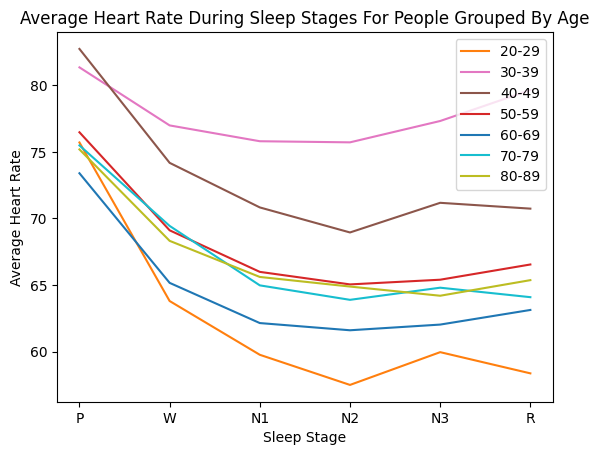

In [36]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["HR"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)

    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.title("Average Heart Rate During Sleep Stages For People Grouped By Age")
plt.ylabel("Average Heart Rate")
plt.xlabel("Sleep Stage")
plt.savefig("average_heart_rate_plot.png", bbox_inches='tight')  # Save the image
plt.show()

In [6]:
for key in patient_records.keys():
    patient_records[key].loc[:,"HR_Divided_Mean"] = patient_records[key]['HR'] /patient_records[key]['HR'].mean()

In [7]:
for key in patient_records.keys():
    patient_records[key].loc[:,"HR_Divided_Median"] = patient_records[key]['HR'] /patient_records[key]['HR'].median()

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\2359439637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 10.26it/s]
13it [00:01,  9.62it/s]
13it [00:01, 11.63it/s]
22it [00:01, 12.05it/s]
19it [00:01, 12.18it/s]
23it [00:01, 12.26it/s]
3it [00:00, 13.47it/s]


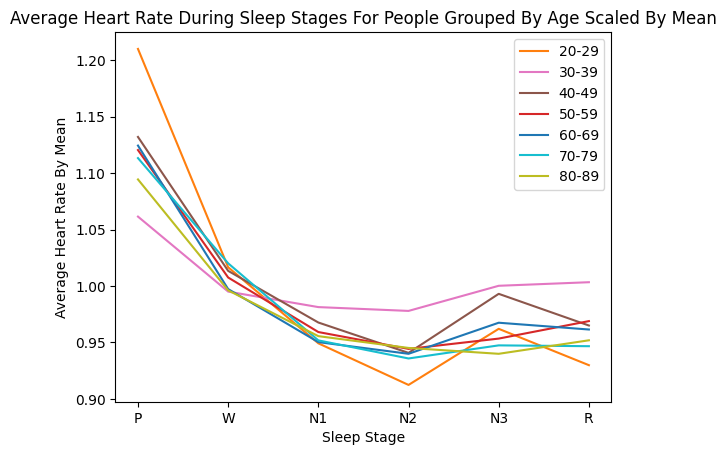

In [40]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["HR_Divided_Mean"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)

    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.title("Average Heart Rate During Sleep Stages For People Grouped By Age Scaled By Mean")
plt.ylabel("Average Heart Rate By Mean")
plt.xlabel("Sleep Stage")
plt.savefig("average_heart_rate_plot_mean.png", bbox_inches='tight')  # Save the image
plt.show()

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\2462952402.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 10.77it/s]
13it [00:01, 11.85it/s]
13it [00:01, 11.12it/s]
22it [00:02,  9.39it/s]
19it [00:01, 11.32it/s]
23it [00:01, 12.97it/s]
3it [00:00, 12.99it/s]


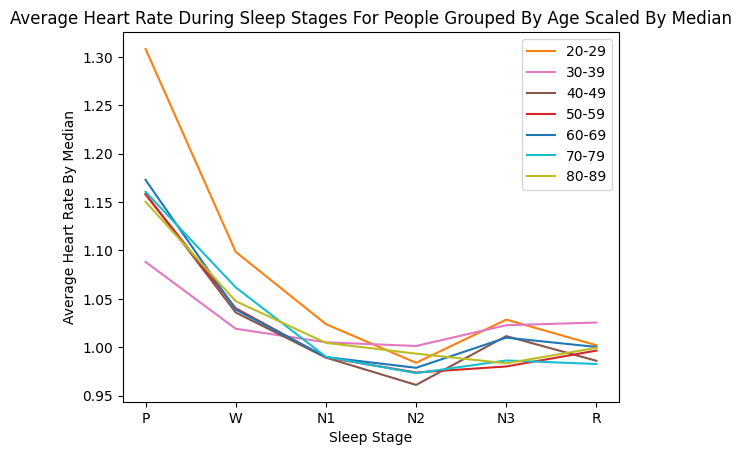

In [41]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["HR_Divided_Median"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)

    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.title("Average Heart Rate During Sleep Stages For People Grouped By Age Scaled By Median")
plt.ylabel("Average Heart Rate By Median")
plt.xlabel("Sleep Stage")
plt.savefig("average_heart_rate_plot_median.png", bbox_inches='tight')  # Save the image
plt.show()

In [33]:
participant_df.loc["S027"]

AGE                                          63.0
GENDER                                          F
BMI                                          32.0
OAHI                                            8
AHI                                             8
Mean_SaO2                                     93%
Arousal Index                                  47
MEDICAL_HISTORY    Body Pain, Depression, Dyspnea
Sleep_Disorders                          Insomnia
Name: S027, dtype: object

In [19]:
participant_df.loc[participant_df["SID"]=="S003"]

,SID,AGE,GENDER,BMI,OAHI,AHI,Mean_SaO2,Arousal Index,MEDICAL_HISTORY,Sleep_Disorders
1,S003,29.38,F,51.0,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn..."


In [16]:
random_patients = np.random.rand(10)*100
random_patients =  np.floor(random_patients)
random_patients

array([27.,  0., 56., 21., 22., 46., 22., 31., 84., 14.])

In [22]:
sleep_stage_order = ["P", "W", "N1", "N2", "N3", "R"]

In [19]:
patient_records["S027"].loc[:,["TEMP","Sleep_Stage"]].groupby("Sleep_Stage").mean()

,TEMP
Sleep_Stage,
Missing,33.623847
N1,34.942602
N2,34.956711
N3,35.683111
P,34.123062
W,34.218529


In [ ]:
for i in random_patients:
    id = patient_records.keys()[i]
    df:pd.DataFrame = patient_records[id]
    

In [15]:
participant_df.columns

Index(['AGE', 'GENDER', 'BMI', 'OAHI', 'AHI', 'Mean_SaO2', 'Arousal Index',
       'MEDICAL_HISTORY', 'Sleep_Disorders', 'asthma', 'body pain', 'gerd',
       'hypertension', 'sleep apnea', 'arrhythmia', 'depression', 'dyspnea',
       'diabetes', 'cad', 'anxiety', 'migraine', 'osa', 'snoring',
       'difficulty breathing', 'difficulty staying asleep', 'snort', 'rls',
       'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia', 'fatigue',
       'morning headaches', 'bruxism', 'snore', 'headache'],
      dtype='object')

In [14]:
unique_groups = pd.unique(participant_df["Age_Group"])
num_colors = len(unique_groups)

colors = plt.cm.tab10(np.linspace(0, 1, num_colors))

group_color_map = dict(zip(unique_groups, colors))

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\4267898750.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 11.31it/s]
13it [00:01, 11.85it/s]
13it [00:01, 12.08it/s]
22it [00:01, 11.82it/s]
19it [00:01, 12.00it/s]
23it [00:01, 12.27it/s]
3it [00:00, 12.73it/s]


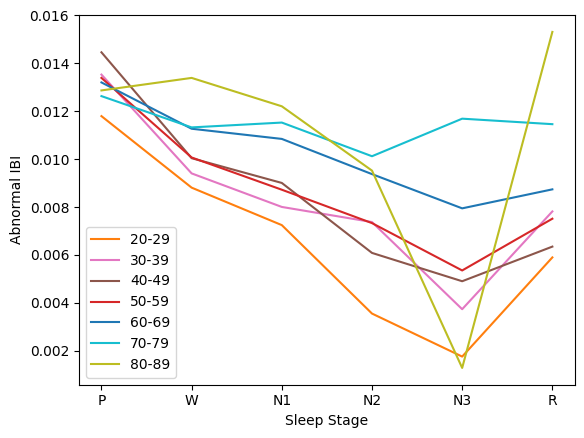

In [16]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["Abnormal_IBI_Moving_4"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)
    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.ylabel("Abnormal IBI")
plt.xlabel("Sleep Stage")
plt.savefig("ibi.png", bbox_inches='tight')  # Save the image
plt.show()

In [8]:
for index in patient_records.keys():
    patient_records[index]["Abnormal_IBI_Moving_4_Mean_Scaled"] =  patient_records[index]["Abnormal_IBI_Moving_4"]/patient_records[index]["Abnormal_IBI_Moving_4"].mean()

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\2465501791.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 11.38it/s]
13it [00:01, 11.99it/s]
13it [00:01, 11.77it/s]
22it [00:01, 12.23it/s]
19it [00:01, 12.18it/s]
23it [00:01, 12.35it/s]
3it [00:00, 11.83it/s]


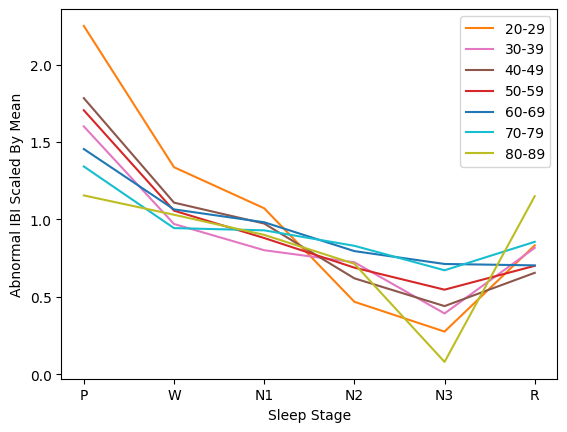

In [32]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["Abnormal_IBI_Moving_4_Mean_Scaled"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)
    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.ylabel("Abnormal IBI Scaled By Mean")
plt.xlabel("Sleep Stage")
plt.savefig("ibi_mean.png", bbox_inches='tight')  # Save the image
plt.show()

100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


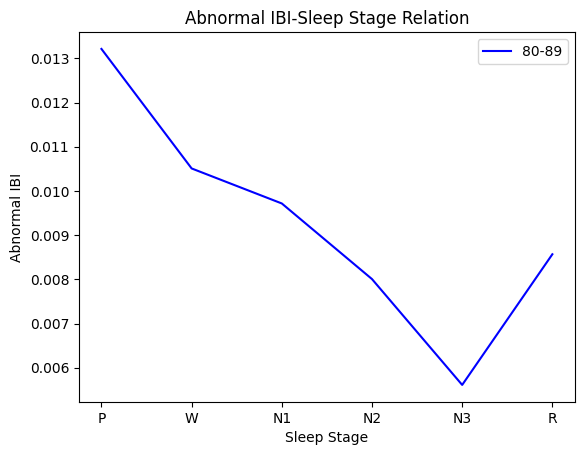

In [33]:
all_means = []
for index, data in tqdm(patient_records.items()):
    mean =  data.groupby("Sleep_Stage")["Abnormal_IBI_Moving_4"].mean()
    all_means.append(mean)
data = pd.DataFrame(all_means)
# Calculate the column-wise mean (mean for each sleep stage across all observations)
row_means = data.mean(axis=0)
row_means = row_means.reindex(["P","W","N1","N2","N3","R"])

plt.plot(row_means,color="blue",label=group_name)
plt.legend()
plt.title("Abnormal IBI-Sleep Stage Relation")
plt.ylabel("Abnormal IBI")
plt.xlabel("Sleep Stage")
plt.savefig("ibi_mean_all.png", bbox_inches='tight')  # Save the image
plt.show()

In [ ]:
bins = range(20, 91, 10)  # from 20 to 90, with step of 10
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # Labels like "20-29", "30-39", etc.

# Group patients by their age
participant_df['Age_Group'] = pd.cut(participant_df['AGE'], bins=bins, labels=labels, right=False)

print(participant_df)

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\3640648304.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 10.57it/s]
13it [00:01, 11.59it/s]
13it [00:01, 11.88it/s]
22it [00:01, 12.47it/s]
19it [00:01, 12.89it/s]
23it [00:01, 13.01it/s]
3it [00:00, 13.76it/s]


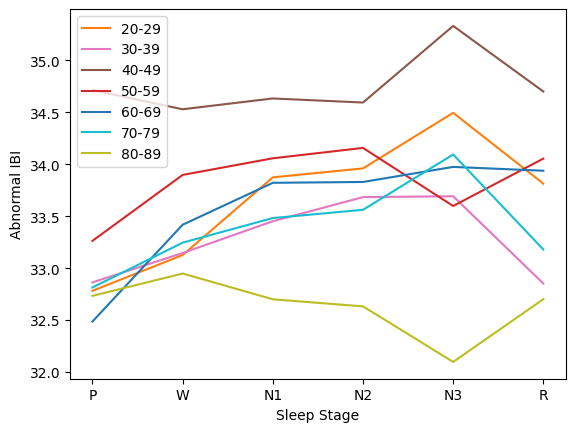

In [ ]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["TEMP"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)
    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.ylabel("Abnormal IBI")
plt.xlabel("Sleep Stage")
plt.show()

C:\Users\alkan\AppData\Local\Temp\ipykernel_17596\522832885.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_data in participant_df.groupby("Age_Group"):
7it [00:00, 12.44it/s]
13it [00:01, 12.82it/s]
13it [00:00, 13.18it/s]
22it [00:01, 12.67it/s]
19it [00:01, 12.35it/s]
23it [00:01, 12.22it/s]
3it [00:00, 14.08it/s]


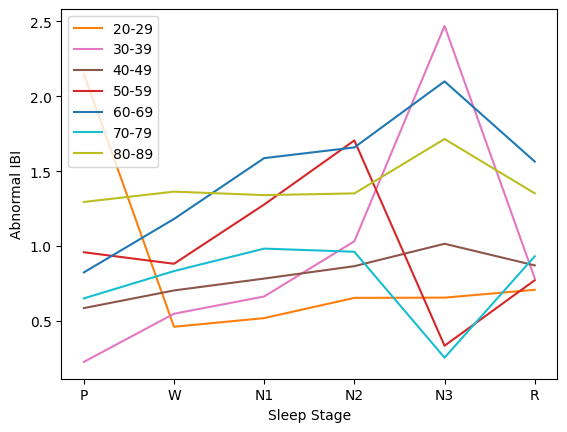

In [49]:
i = 0
for group_name, group_data in participant_df.groupby("Age_Group"):
    all_means = []
    for index, data in tqdm(group_data.iterrows()):
        if not index in patient_records.keys():
            continue
        mean =  patient_records[index].groupby("Sleep_Stage")["EDA"].mean()
        all_means.append(mean)
    data = pd.DataFrame(all_means)
    # Calculate the column-wise mean (mean for each sleep stage across all observations)
    row_means = data.mean(axis=0)
    row_means = row_means.reindex(["P","W","N1","N2","N3","R"])
    plt.plot(row_means,color=group_color_map[group_name],label=group_name)
    i+=1
plt.legend()
plt.ylabel("Abnormal IBI")
plt.xlabel("Sleep Stage")
plt.show()

In [51]:
patient_records["S002"]

,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage,...,IBI_Moving_Average_640,IBI_Moving_STD_640,Abnormal_IBI_Moving_3,Abnormal_IBI_Moving_4,ACC,Abnormal_IBI_Moving_4_Mean_Scaled,Abnormal_IBI_Moving_4_Median_Scaled,HR_Divided_Mean,HR_Divided_Median,TEMPXEDA
0,0.000000,5.14,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0.796875,0.0,0,0,63.639610,0.0,NaN,0.694094,0.730471,2.593868
1,0.015625,4.28,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0.796875,0.0,0,0,63.639610,0.0,NaN,0.694094,0.730471,2.593868
2,0.031250,3.51,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0.796875,0.0,0,0,63.639610,0.0,NaN,0.694094,0.730471,2.593868
3,0.046875,3.02,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0.796875,0.0,0,0,63.639610,0.0,NaN,0.694094,0.730471,2.593868
4,0.062500,2.94,28.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0.796875,0.0,0,0,62.233432,0.0,NaN,0.694094,0.730471,2.593868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013692,31463.937500,120.17,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,...,1.046875,0.0,0,0,64.536811,0.0,NaN,1.106725,1.164729,5.028482
2013693,31463.953125,106.78,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,...,1.046875,0.0,0,0,64.536811,0.0,NaN,1.106725,1.164729,5.028482
2013694,31463.968750,98.52,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,...,1.046875,0.0,0,0,65.314623,0.0,NaN,1.106725,1.164729,5.028482
2013695,31463.984375,95.02,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,...,1.046875,0.0,0,0,65.314623,0.0,NaN,1.106725,1.164729,5.028482


100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


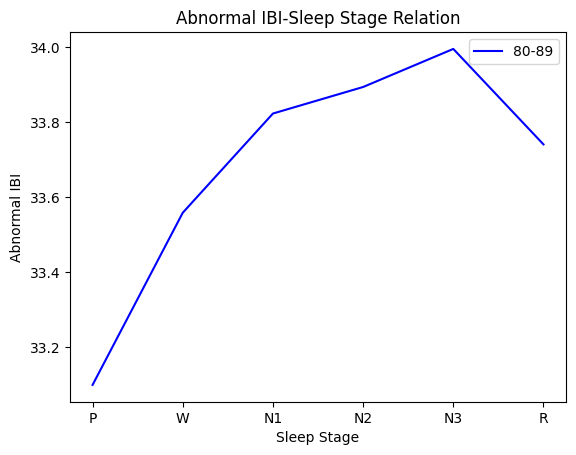

In [42]:
all_means = []
for index, data in tqdm(patient_records.items()):
    mean =  data.groupby("Sleep_Stage")["TEMP"].mean()
    all_means.append(mean)
data = pd.DataFrame(all_means)
# Calculate the column-wise mean (mean for each sleep stage across all observations)
row_means = data.mean(axis=0)
row_means = row_means.reindex(["P","W","N1","N2","N3","R"])

plt.plot(row_means,color="blue",label=group_name)
plt.legend()
plt.title("Abnormal IBI-Sleep Stage Relation")
plt.ylabel("Abnormal IBI")
plt.xlabel("Sleep Stage")
#plt.savefig("ibi_mean_all.png", bbox_inches='tight')  # Save the image
plt.show()

This feature is meaningful, people usually have the changing ibi values in N2 stage, but the person with anxiety have increased values of ibi when woke and preparation stage.

Bu özelliği nasıl geliştirebiliriz, modelin anxiety ile birlikte yorumlamasını nasıl sağlayabiliriz?

### Min-Max Normalization

In [ ]:
patient_records["S002"]

,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage,...,Central_Apnea,Hypopnea,Multiple_Events,IBI_Moving_Average_640,IBI_Moving_STD_640,Abnormal_IBI_Moving_3,Abnormal_IBI_Moving_4,ACC,HR_Divided_Mean,HR_Divided_Median
0,0.000000,5.14,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0,0,0,0.796875,0.0,0,0,63.639610,0.694094,0.730471
1,0.015625,4.28,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0,0,0,0.796875,0.0,0,0,63.639610,0.694094,0.730471
2,0.031250,3.51,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0,0,0,0.796875,0.0,0,0,63.639610,0.694094,0.730471
3,0.046875,3.02,31.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0,0,0,0.796875,0.0,0,0,63.639610,0.694094,0.730471
4,0.062500,2.94,28.0,8.0,55.0,35.53,0.073005,49.00,0.796875,P,...,0,0,0,0.796875,0.0,0,0,62.233432,0.694094,0.730471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013692,31463.937500,120.17,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,...,0,0,0,1.046875,0.0,0,0,64.536811,1.106725,1.164729
2013693,31463.953125,106.78,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,...,0,0,0,1.046875,0.0,0,0,64.536811,1.106725,1.164729
2013694,31463.968750,98.52,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,...,0,0,0,1.046875,0.0,0,0,65.314623,1.106725,1.164729
2013695,31463.984375,95.02,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,...,0,0,0,1.046875,0.0,0,0,65.314623,1.106725,1.164729


In [9]:
columns_to_normalize = patient_records["S002"].select_dtypes("float64").columns#["BVP","ACC_X","ACC_Y","ACC_Z","TEMP","EDA","HR","ACC"]

global_min = {col: np.inf for col in columns_to_normalize}
global_max = {col: -np.inf  for col in columns_to_normalize}

for df_name, df in patient_records.items():
    for col in columns_to_normalize:
        # Update the global minimum for the column
        global_min[col] = min(global_min[col], df[col].min())
        global_max[col] = max(global_max[col], df[col].max())

In [10]:

normalized_records = {}
for key,df in tqdm(patient_records.items()):
    for column in columns_to_normalize:  
        col_min = global_min[column]
        col_max = global_max[column]

        if col_max != col_min:
            df[column] = (df[column] - col_min) / (col_max - col_min)
        else:
            df[column] = 0

    normalized_records[key] = df

100%|██████████| 98/98 [01:40<00:00,  1.02s/it]


In [11]:
columns = [ 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI',
       'Multiple_Events', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled']
columns_participant=['AGE', 'GENDER', 'BMI','asthma',
       'body pain', 'gerd', 'hypertension', 'sleep apnea', 'arrhythmia',
       'depression', 'dyspnea', 'diabetes', 'cad', 'anxiety', 'migraine',
       'osa', 'snoring', 'difficulty breathing', 'difficulty staying asleep',
       'snort', 'rls', 'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia',
       'fatigue', 'morning headaches', 'bruxism', 'snore', 'headache']

In [14]:
rng = np.random.default_rng(seed = 30)
test_validation_indexes = rng.random(30)
a, b = 0, len(patient_records.keys())  # Example range
test_validation_indexes = np.floor(a + (b - a) * test_validation_indexes)
test_validation_indexes = [int(i) for i in test_validation_indexes]

participant_df = pd.read_csv("participant_info_processed.csv",index_col="SID")
participant_df["GENDER"] = participant_df["GENDER"].apply(lambda x: 1 if x =="M" else 0)

validation_indexes = test_validation_indexes[:15]
test_indexes = test_validation_indexes[15:]
print(validation_indexes,test_indexes)
train_set = {}
for i,v in tqdm(normalized_records.items()):
    train_set[i] = v.loc[v["Sleep_Stage"]!="P"]
    for column in columns_participant:
        train_set[i].loc[:,column] = participant_df.loc[i,column]



[23, 42, 9, 58, 76, 85, 31, 10, 39, 57, 24, 63, 88, 38, 46] [75, 59, 72, 49, 86, 15, 58, 9, 94, 42, 11, 88, 91, 23, 31]


  0%|          | 0/98 [00:00<?, ?it/s]C:\Users\alkan\AppData\Local\Temp\ipykernel_5588\3351292697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
C:\Users\alkan\AppData\Local\Temp\ipykernel_5588\3351292697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
C:\Users\alkan\AppData\Local\Temp\ipykernel_5588\3351292697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of

MemoryError: Unable to allocate 11.5 MiB for an array with shape (1511041,) and data type int64

In [ ]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()

for i,key in tqdm(enumerate(list(normalized_records.keys()))):
    if i in test_indexes or i in validation_indexes:
        test_df= pd.concat([test_df,train_set[key]],ignore_index=True)
    else:
        train_df= pd.concat([train_df,train_set[key]],ignore_index=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [ ]:
X_train, y_train = train_df.drop("Sleep_Stage",axis=1),train_df["Sleep_Stage"]
X_test, y_test = test_df.drop("Sleep_Stage",axis=1),test_df["Sleep_Stage"]
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,  # Maximum depth of a tree
    random_state=42,  # For reproducibility
    use_label_encoder=False  # Avoid warning in recent XGBoost versions
)

# Train the model
model.fit(X_train, y_train_encoded) 

In [ ]:
# Make predictions
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_score,recall_score
y_pred = model.predict(X_test)

# Evaluate the model

acc = accuracy_score(y_test_encoded, y_pred)
f1,pre,rec = f1_score(y_test_encoded, y_pred,average="macro"),precision_score(y_test_encoded, y_pred,average="macro"),recall_score(y_test_encoded, y_pred,average="macro")
acc,f1,pre,rec

In [11]:
shrinked_records = {}
for i,v in tqdm(normalized_records.items()):
    shrinked_records[i] = pipeline_script.shrink_data(v,5)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [02:46<00:00,  1.70s/it]


In [9]:
shrinked_records = {}
for i,v in tqdm(normalized_records.items()):
    shrinked_records[i] = pipeline_script.shrink_data(v,2)

100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


In [ ]:
for i in range():
    normalized_records

In [10]:
import polars as pl
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Define a function to write CSV
def write_csv(key, value):
    pl.from_pandas(value).write_csv(f"normalized_data_10/{key}_whole_df.csv")

# Parallelized file writing
for i,v in tqdm(shrinked_records.items()):
    write_csv(i,v)

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


In [12]:
for i,v in tqdm(shrinked_records.items()):
    v.to_csv(f"normalized_data_5/{i}_whole_df.csv",index=False)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [13:04<00:00,  8.00s/it]


*IBI heart rate düzensiliği hesapla aritmi ile ilişkilendir vs. (df.roll) df roll ile çıkarıabliecek featurelar var 
*varyans hesapla 
*disorderlar ile gender ve diğer özellikleri ilişkilendir
*arousal index ile body tmep, heart rate gender acc'leri ilişkilendir, acc'yi ve diğer değerleri yanlış yorumlamanın önüne geç
*datayı ortalamalarını alarak küçült mesela 10 row'u 3 rowa düşür


### araştırmamız faydalı olan ilişkiler vs. nelerdir

We will choose 5 patients to analyze feature importances on, for randomization of the selected patients, we will use random.randint

### Tahmin modeli yaparken datasetin sonunu bilmiyormuş gibi sadece başını alıp bir sonraki sleep stage'i tahmin etme şeklinde bir metot izlemeli miyiz

Timestamp ve uyku süresi kullan.
Çeşitli uyku evrelerinde yaşanan bozuklular ve medical history ve sleep disorder ilişkilendir
n1'deki süre uykuya dalmadaki güçlüğü işaret ediyor olabilir. sadece 1 kere oluyor
rem ilk cycle'da daha kısa sürüyor
New born stay more in rem, ve